In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


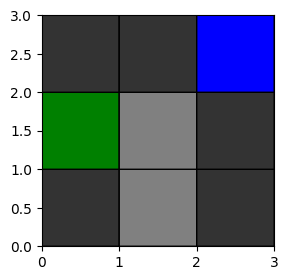

In [8]:
from types import SimpleNamespace
import os
os.environ['CUDA'] = '/usr/local/cuda-12'
os.environ['PATH'] = '/usr/local/cuda-12/bin${PATH:+:${PATH}}'

import jax as jx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colors
import json
import environments
import math

with open('configs/ER.json', 'r') as f:
    config = json.load(f)

def render(state):
    goal, walls, pos = state
    cmap = colors.ListedColormap(['#333333','grey', 'green', 'blue'])
    arr = jnp.array(walls, dtype=int)
    arr = arr.at[goal[0], goal[1]].set(2)
    arr = arr.at[pos[0], pos[1]].set(3)
    plt.figure(figsize=(3,3))
    plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1)


def set_default(d, k, v):
    if k not in d:
        d[k] = v

set_default(config, "double_DQN", False)
set_default(config, "episodic_env", False)
set_default(config, "updates_per_step", 1)
set_default(config, "save_final_params", True)
config = SimpleNamespace(**config)

Environment = getattr(environments, config.environment)

env_config = config.env_config

key = jx.random.PRNGKey(0)
env = Environment(**env_config)
state, obs = env.reset(key)
render(state)

-1 False


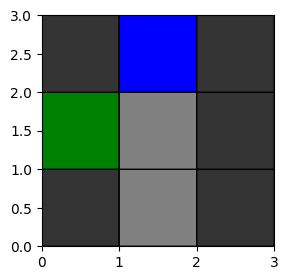

In [9]:
new_state, new_obs, rew, terminal, info = env.step(key, state, 2)
render(new_state)
print(rew, terminal)

In [10]:
type(state[1])

jaxlib.xla_extension.ArrayImpl

In [11]:
import pickle as pkl
with open('out/ER.params', 'rb') as f:
    data = pkl.load(f)
len(data['Q'])

30

Array([-4.7395477, -4.7612224, -4.1903167, -4.404432 , -4.909163 ],      dtype=float32)

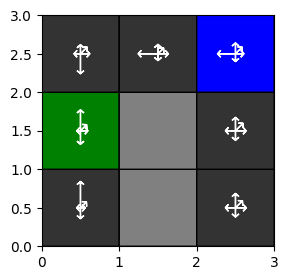

In [12]:
import haiku as hk
activation_dict = {"relu": jx.nn.relu, "silu": jx.nn.silu, "elu": jx.nn.elu}

class Q_function(hk.Module):
    def __init__(self, config, num_actions, name=None):
        super().__init__(name=name)
        self.num_hidden_units = config.num_hidden_units
        self.num_hidden_layers = config.num_hidden_layers
        self.activation_function = activation_dict[config.activation]
        self.num_actions = num_actions

    def __call__(self, phi):
        x = jnp.ravel(phi)
        for i in range(self.num_hidden_layers):
            x = self.activation_function(hk.Linear(self.num_hidden_units)(x))
        Q = hk.Linear(self.num_actions)(x)
        return Q

Q_net = hk.without_apply_rng(hk.transform(lambda phi: Q_function(config, env.num_actions())(phi)))
# Q_net.init(key, env.num_actions())
Q_func = Q_net.apply


def render_q(stat):
    render(stat)
    scale = 0.7
    goal, walls, player = stat
    move_map = env.move_map.astype(float)
    move_map = move_map.at[0].set([1/math.sqrt(2), 1/math.sqrt(2)]) # plot inaction as diagonal
    for i in range(walls.shape[0]):
        for j in range(walls.shape[1]):
            if walls[i, j]:
                continue
            player = jnp.array((i, j))
            ob = env.get_observation((goal, walls, player))
            qs = Q_func(data['Q'][10], ob)
            qs = jx.nn.softmax(qs)

            for a, q in enumerate(qs):
                arr_dir = move_map[a]
                plt.arrow(player[1] + 0.5, player[0] + 0.5, scale*arr_dir[1]*q, scale*arr_dir[0]*q, head_width=0.09, head_length=0.04, length_includes_head=True, color='white', overhang=1)

render_q(state)
Q_func(data['Q'][0], obs)

Array([-4.317593 , -4.266589 , -3.7809174, -4.284928 , -4.3931484],      dtype=float32)

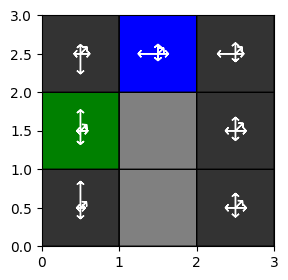

In [13]:
render_q(new_state)
Q_func(data['Q'][0], new_obs)

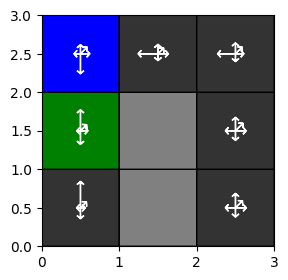

In [14]:
new_state2, new_obs2, rew2, terminal2, info2 = env.step(key, new_state, 2)
render_q(new_state2)

In [15]:
with open('out/simple_model.out', 'rb') as f:
    metrics = pkl.load(f)
metrics['metrics'].keys()

dict_keys(['reward_rates', 'eval_times'])

In [16]:
data['Q'][0]

{'q_function/linear': {'b': Array([-0.01113075,  0.02359411,  0.0079908 , -0.01695957,  0.00766847,
         -0.01689483,  0.01433938,  0.01294269,  0.00393858,  0.03682658,
         -0.01500178,  0.0067021 , -0.01236951,  0.01736413,  0.02727708,
          0.02353875,  0.00198457,  0.02432992, -0.0073505 ,  0.00710996,
         -0.01408074,  0.00080538,  0.02443939,  0.02974592, -0.00149903,
         -0.01561721,  0.0275788 , -0.00588433,  0.02565859,  0.02782875,
         -0.00175186,  0.02806641,  0.01899047, -0.00225105,  0.01315594,
          0.0066869 ,  0.04158954, -0.00461232,  0.00866148,  0.01012414,
         -0.00473944, -0.00721533,  0.02266662,  0.01010914, -0.01071384,
          0.01734398,  0.02261019,  0.00447042,  0.01400933, -0.0081    ,
          0.00026642, -0.0090214 ,  0.01400036, -0.00146788,  0.0378198 ,
          0.01259848,  0.00346056,  0.00529571,  0.0089101 ,  0.024585  ,
          0.00343845,  0.00499654,  0.02923124,  0.02711613,  0.02640804,
         -0.